In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
plt.style.use("~/nice.mplstyle")

In [3]:
metric = "rmse"

In [4]:
nice_names = {
    "sp": "Surface Pressure",
    "u10": "10m Zonal Wind",
    "v10": "10m Meridional Wind",
    "t2m": "2m Temperature",
    "sh2": "2m Specific Humidity",
    "gh": "Geopotential Height",
    "u": "Zonal Wind",
    "v": "Meridional Wind",
    "w": "Vertical Velocity",
    "t": "Temperature",
    "q": "Specific Humidity",
}

In [5]:
def single_plot(ax, dsdict, varname, sel=None, **kwargs):
    xticks = None
    for label, xds in dsdict.items():
        
        plotme = xds[varname] if sel is None else xds[varname].sel(**sel)
        if xticks is None:
            xticks = plotme.fhr.values
        df = plotme.to_dataframe().reset_index()
        if label == "HRRR":
            color="gray"
        elif label == "THRRR":
            color="black"
        else:
            color=None
        sns.lineplot(
            data=df,
            x="fhr",
            y=varname,
            ax=ax,
            label=label,
            color=color,
            **kwargs,
        )
    xticks = xticks if len(xticks)<10 else np.concatenate([ [xticks[0]], xticks[4::4]])
    ax.set(
        ylabel=metric.upper() if ax.get_subplotspec().is_first_col() else "",
        xlabel="Forecast Hour" if ax.get_subplotspec().is_last_row() else "",
        title=nice_names[varname] if ax.get_subplotspec().is_first_row() else "",
        xticks=xticks,
    )
    ax.legend(frameon=False)

In [6]:
def plot_surface_error(surface_vars, dsdict, model_filter=None, **kwargs):
    ncols = len(surface_vars)
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 4), constrained_layout=True)

    if len(surface_vars) == 1:
        axs = [axs]
    for varname, ax in zip(surface_vars, axs):
        single_plot(ax=ax, dsdict=dsdict, varname=varname, **kwargs)
    return fig, axs

In [7]:
def plot_level_vars(level_vars, dsdict, **kwargs):
    
    levels = dsdict["HRRR"].level.values
    ncols = len(level_vars)
    nrows = len(levels)
    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.5*nrows), constrained_layout=True)

    if len(levels) == 1:
        axs = [axs]
    if len(level_vars) == 1:
        axs = [axs]

    sel = kwargs.pop("sel", {})
    for level, axr in zip(levels, axs):
        for varname, ax in zip(level_vars, axr):
            
            sel["level"] = level
            single_plot(ax=ax, dsdict=dsdict, varname=varname, sel=sel, **kwargs)
            ax.legend(title=f"{level} hPa", frameon=False)
    return fig, axs

## Compare 24h and 6h time step in loss


### Data Years

In [13]:
years = {}
for shortname, nicename in zip(
    ["base", "operational"],
    ["mse24h - all", "mse24h - operational"],
):
    years[nicename] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse24h/experiments/data-years/{shortname}/inference-validation/{metric}.nested-lam.nc", decode_timedelta=True)

years["mse06h"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mse06h/experiments/regularization/wp01/inference-validation/{metric}.nested-lam.nc", decode_timedelta=True)
years["HRRR"] = xr.open_dataset(f"/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/baselines/hrrr-forecasts-vs-hrrr-analysis/trimmed/{metric}.lam.nc", decode_timedelta=True)

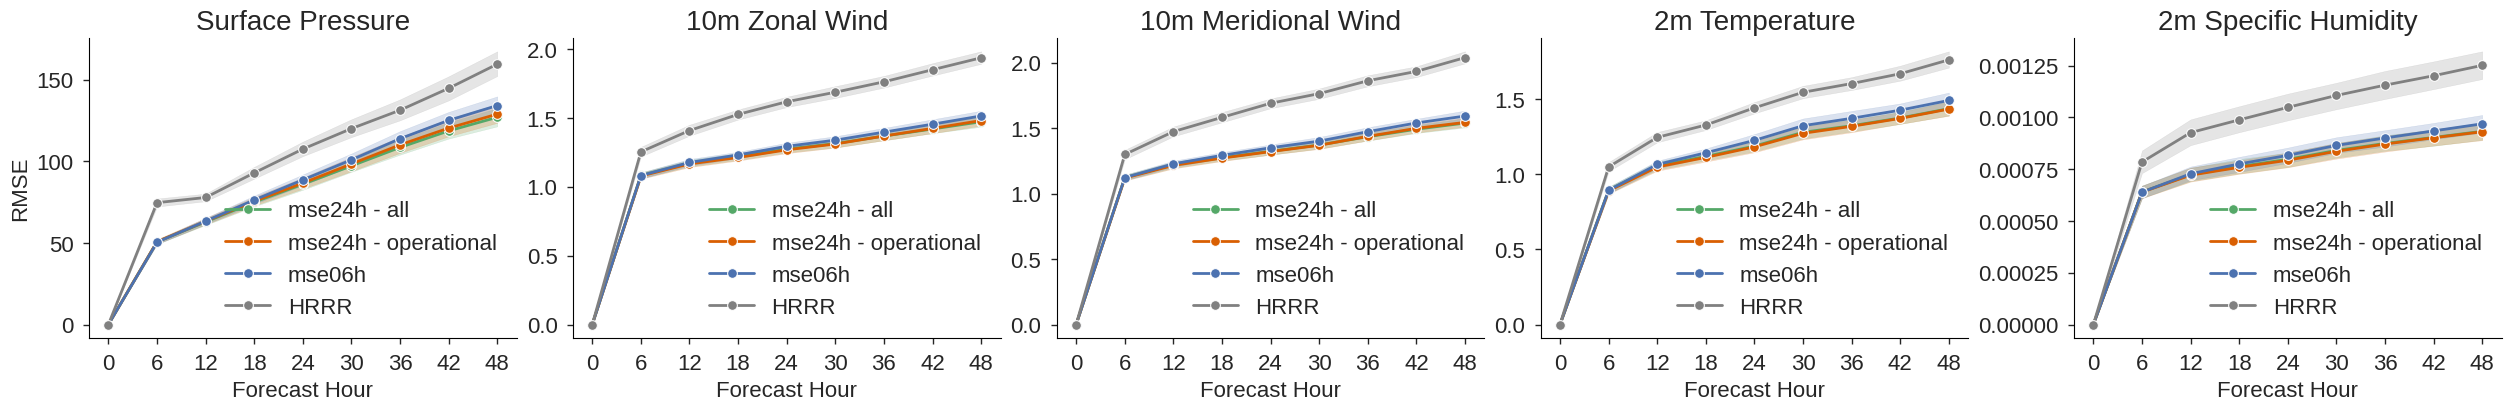

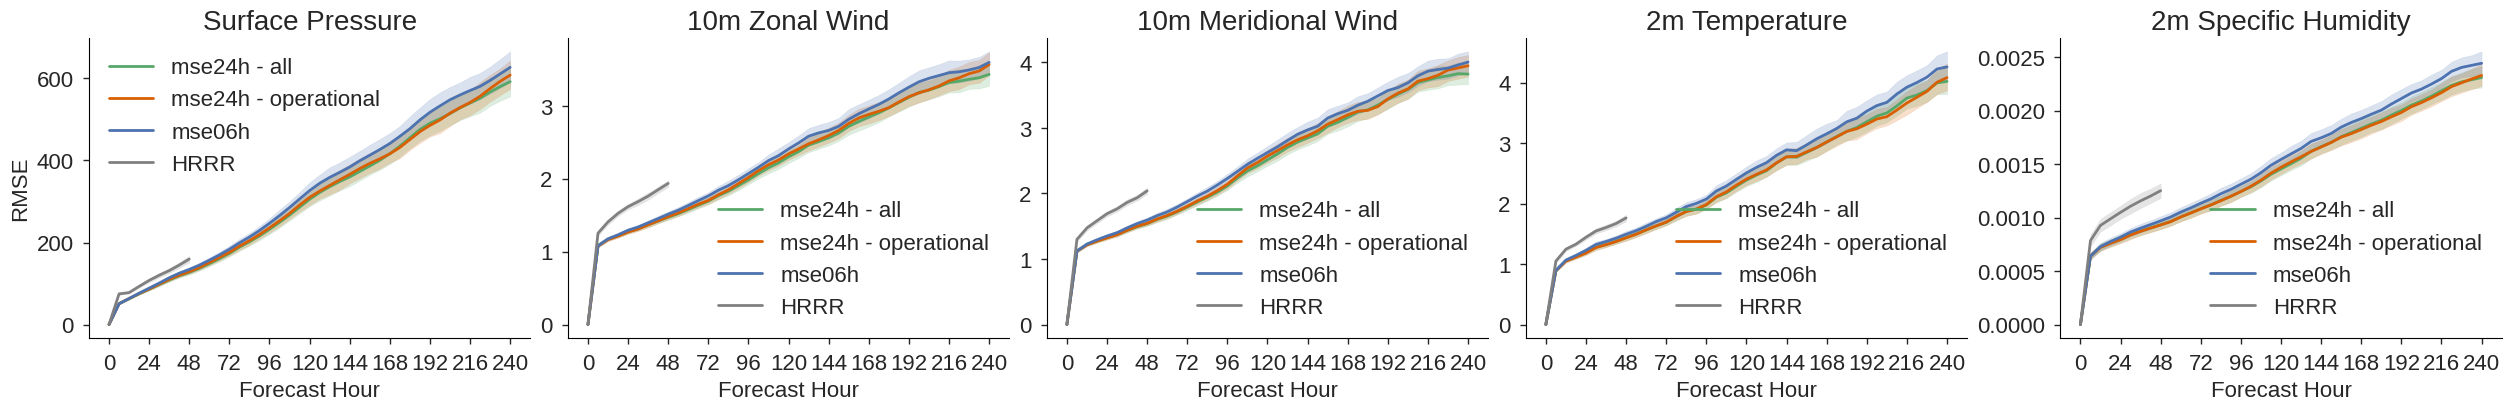

In [14]:
for kwargs in [{"sel": {"fhr": slice(49)}, "marker": "o"}, {}]:
    plot_surface_error(
        ["sp", "u10", "v10", "t2m", "sh2"],
        dsdict=years,
        **kwargs,
    );

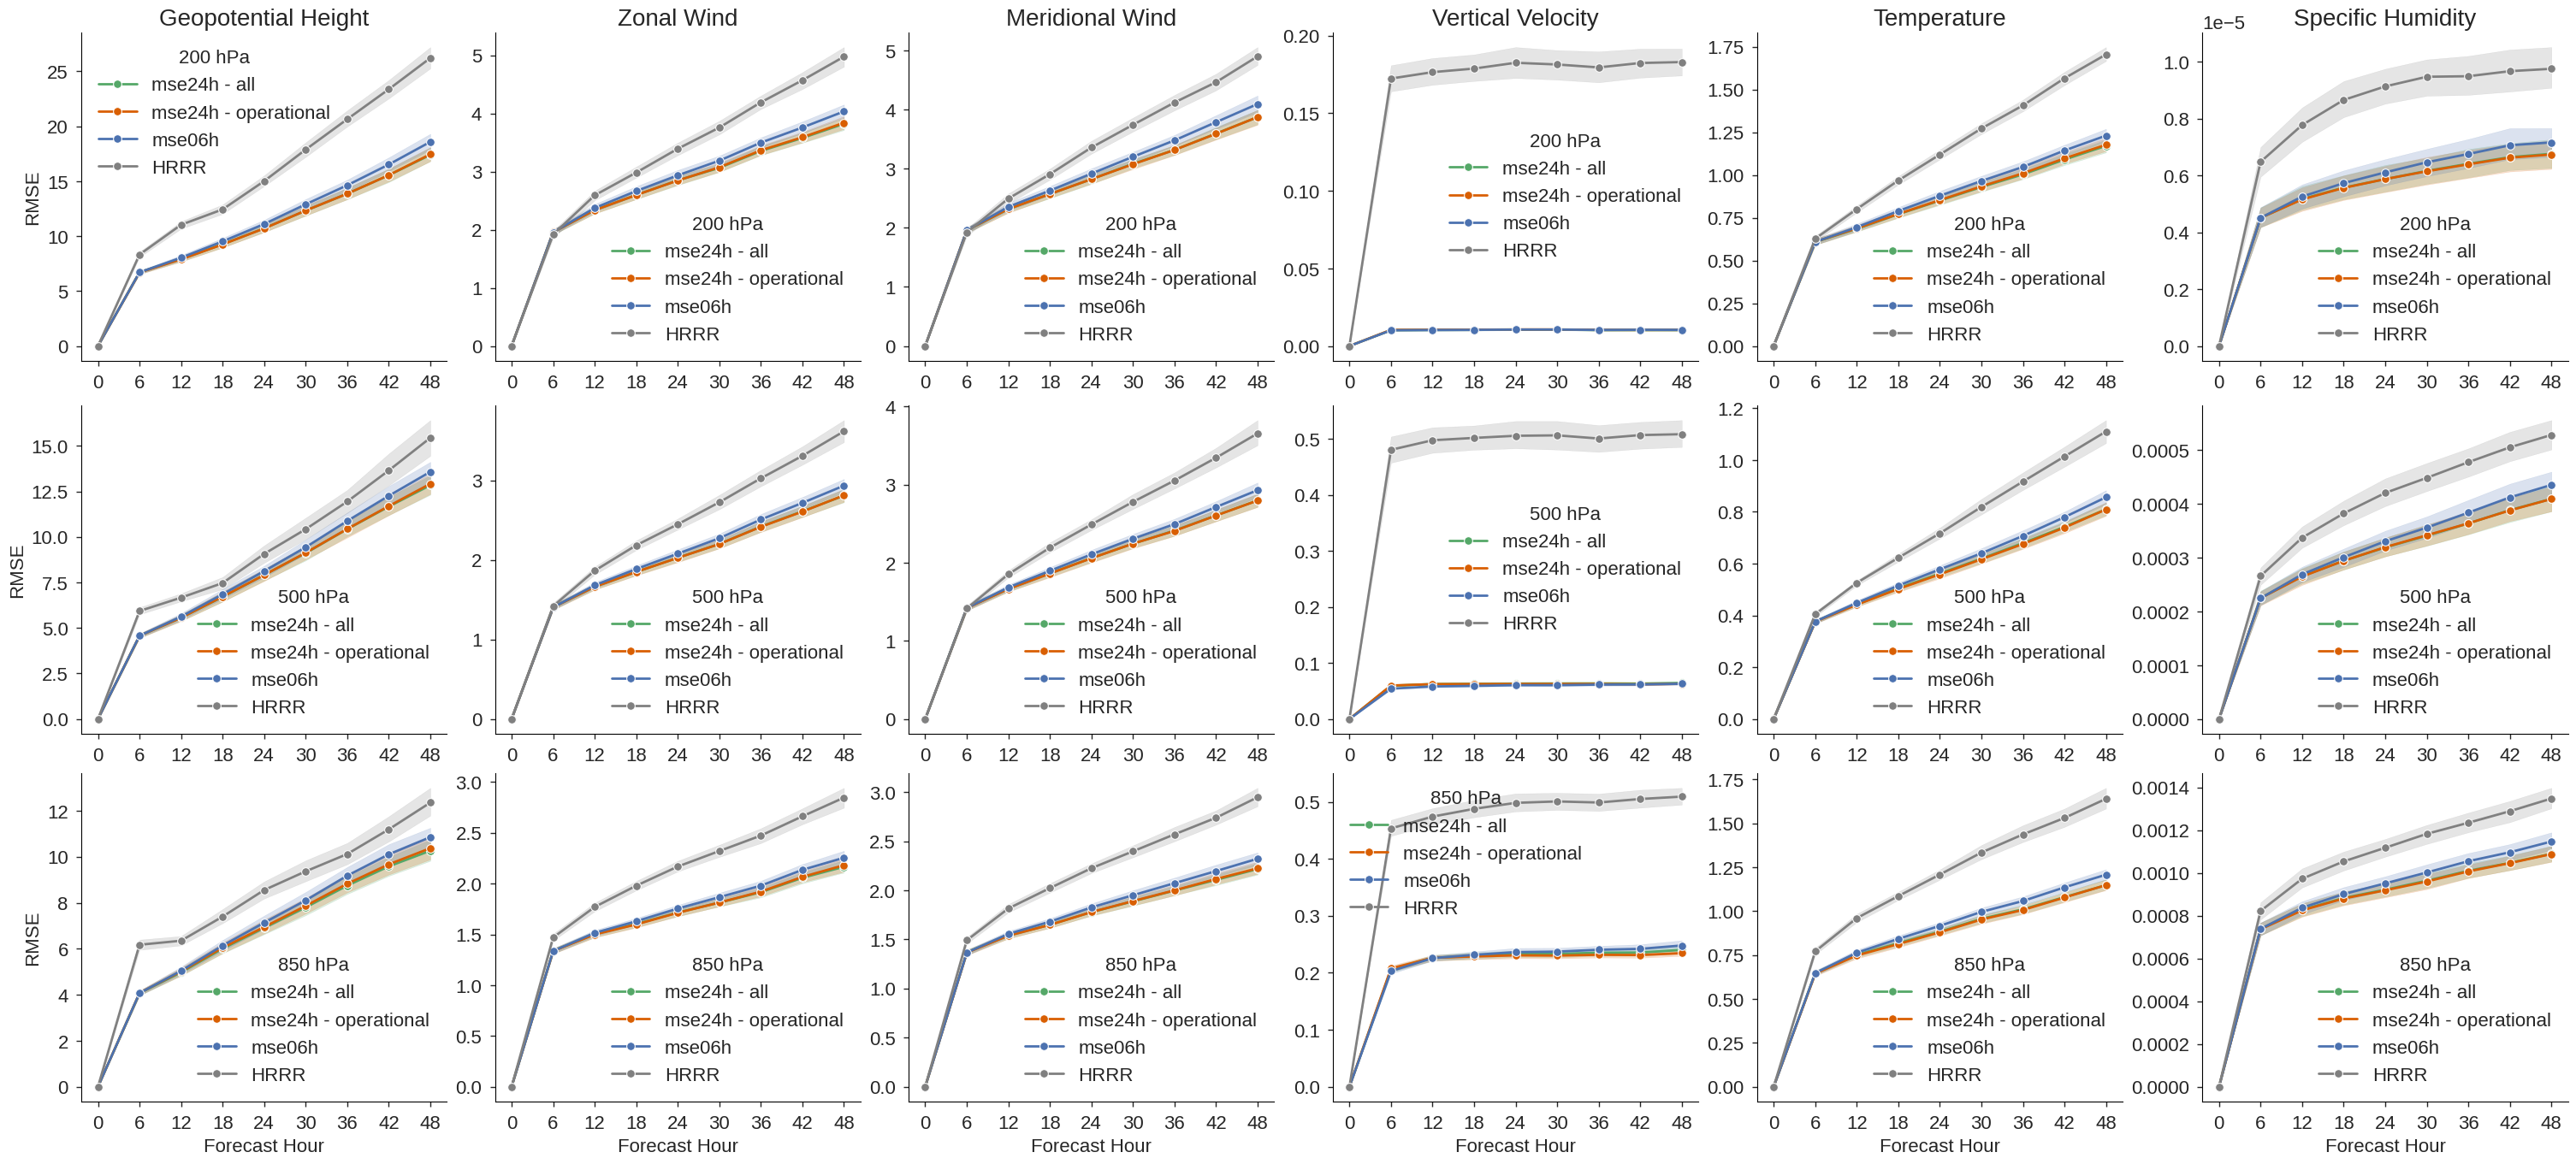

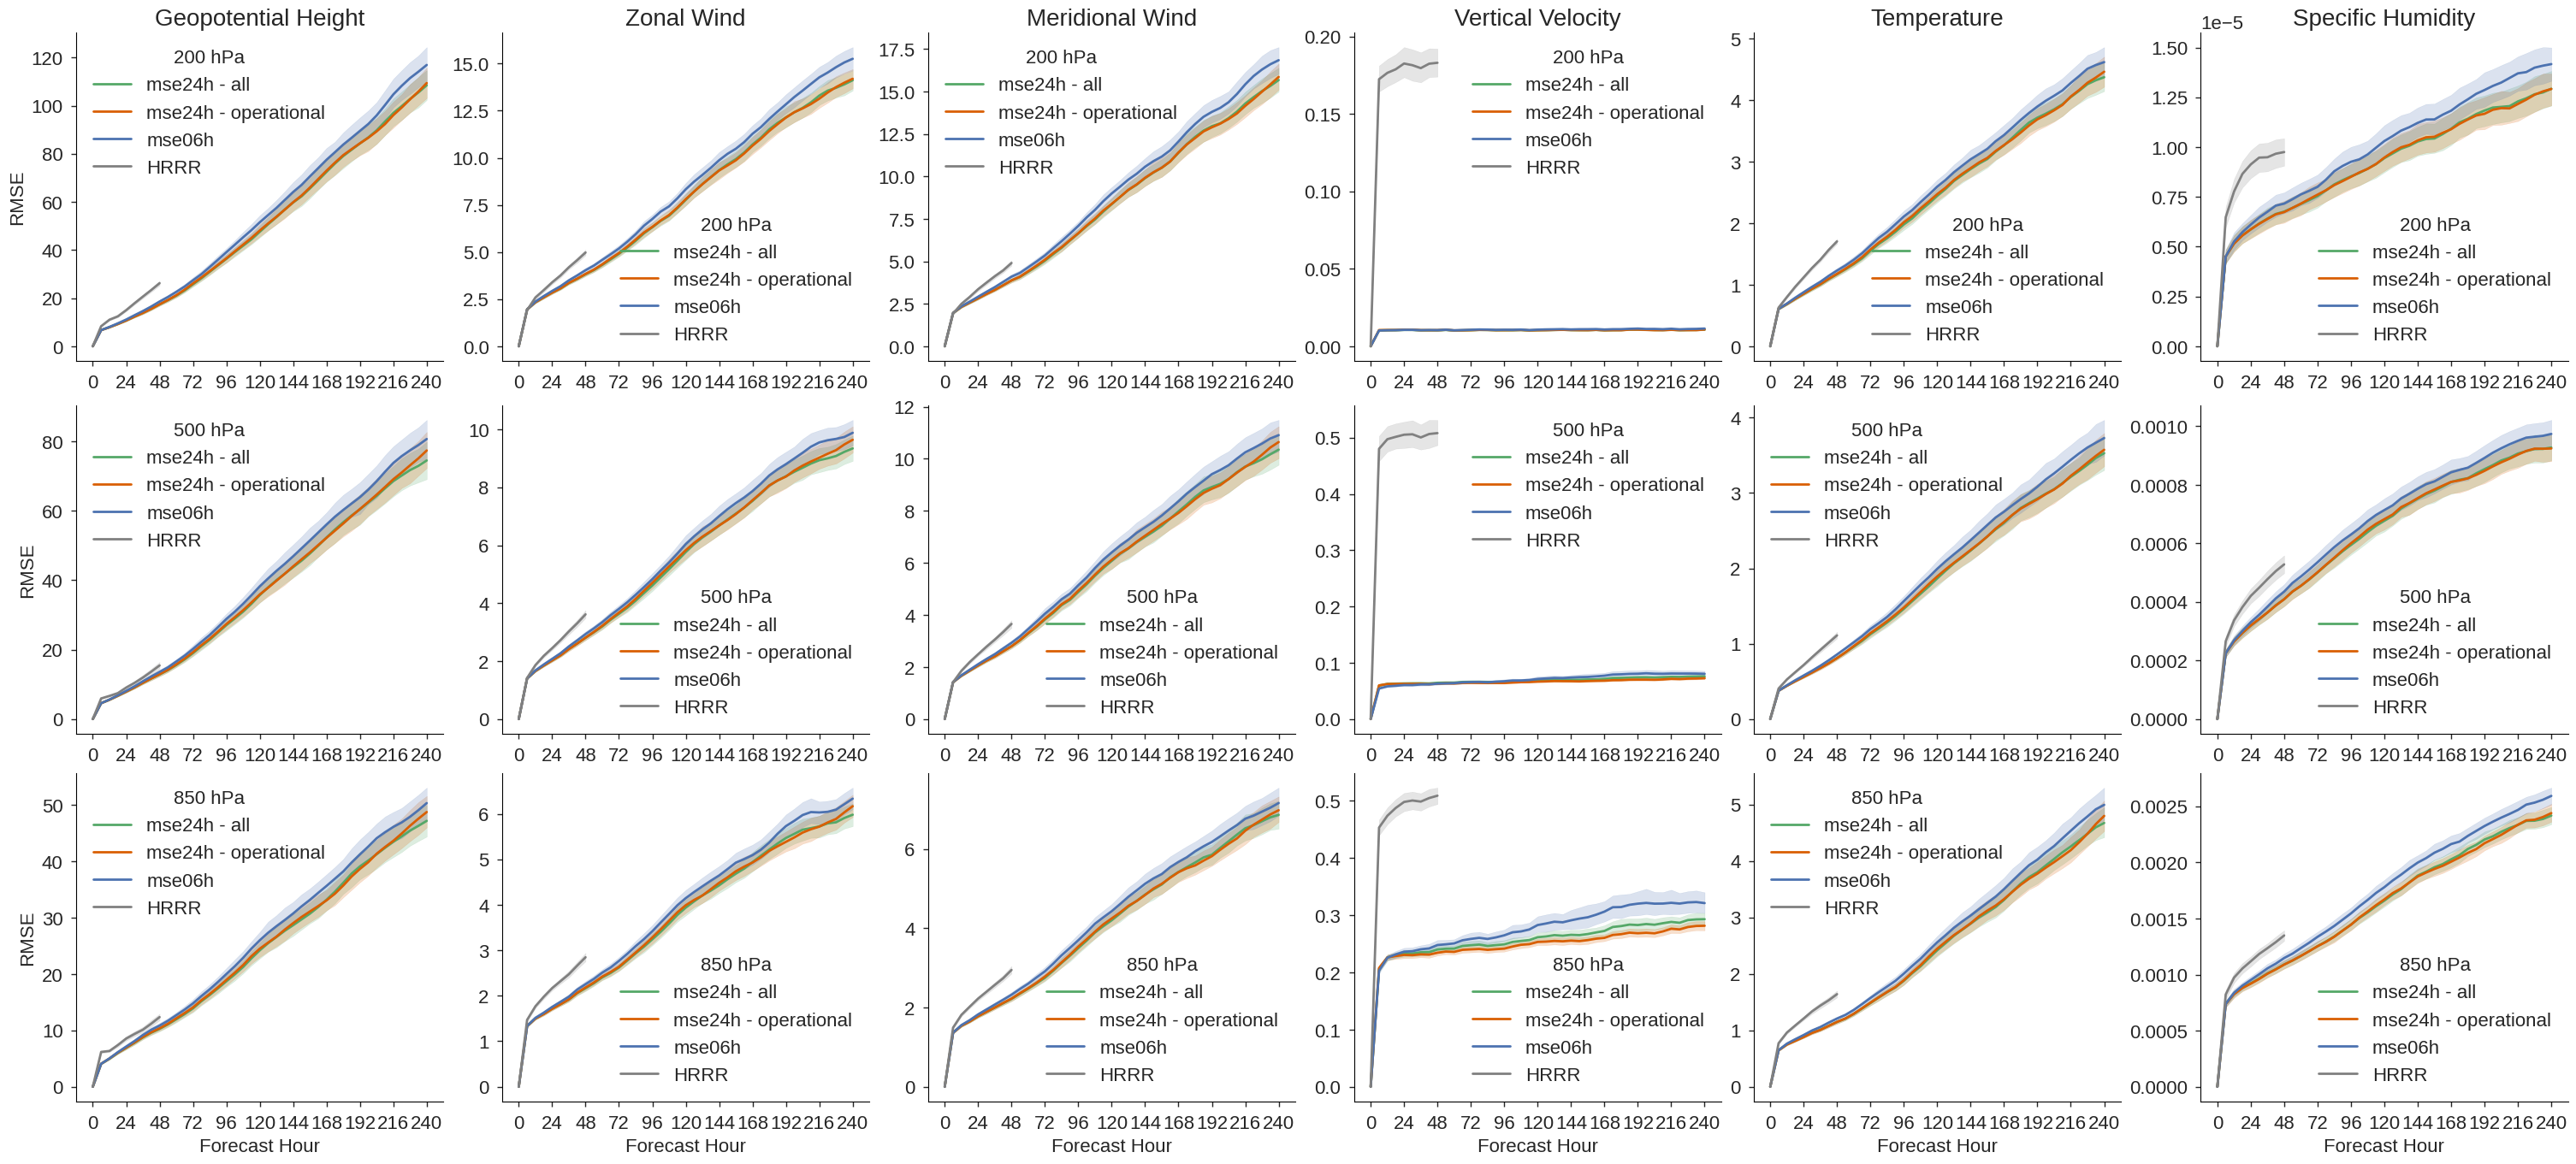

In [15]:
for kwargs in [{"sel": {"fhr": slice(49)}, "marker": "o"}, {}]:
    plot_level_vars(
        ["gh", "u", "v", "w", "t", "q"],
        dsdict=years,
        **kwargs,
    )